## Spectral Clustering

Segmentation is an important task in computer vision. We will use spectral clustering for segmentation. We will use normalized cut after defining similarity between pixels based on distance and color. 

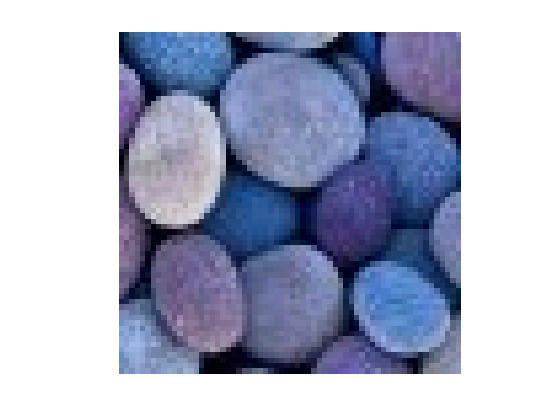

In [1]:
# Read image file
im_orig = imread('stones_rgb.jpg');
imshow(im_orig);

In [2]:
im = double(im_orig); # for matrix operations
# Sizes of the image
[h, ~, ~] = size(im);
n = h * h;
# We already can reach pixels using single indices

In [3]:
## Construct similarity matrix W
W = zeros(n, n);
r = 2;
sigma = 10;
Lambda = [... 
    0.299, 0.587, 0.114; ...
    -0.14713, -0.28886, 0.436; ...
    0.615, -0.51499, -0.10001 ...
];

# only compute upper half
for i = 1:n
    for j = i+1:n
        # Convert values back to coordinates
        # A simple arithmetic solution
        x_i = mod(mod(i, h) + h - 1, h) + 1;
        x_j = mod(mod(j, h) + h - 1, h) + 1;
        y_i = (i - x_i) / h + 1;
        y_j = (j - x_j) / h + 1;
        
        if(abs(x_i - x_j) <= r && abs(y_i - y_j) <= r)
            # weighted distance
            diff = im(x_i, y_i, :) - im(x_j,y_j, :);
            # reshape diff as a vector
            diff = reshape(diff, 3, 1);
            weighted_dist = diff' * Lambda * diff;
            sim = exp(- (weighted_dist) / (2 * sigma^2));
            # assign W(i, j) and W(j, i)
            W(i, j) = sim;
            W(j, i) = sim;
        end
    end
end

In [4]:
## Construct diagonal degree matrix D
D = zeros(n, n);
for i = 1:n
    D(i, i) = sum(W(i, :));
end

In [5]:
## Construct Laplacian matrix L
# (It should not be costly to take inverse of diagonal matrix D)
D_invSqrt = inverse(sqrtm(D));
L = D_invSqrt * W * D_invSqrt;

In [7]:
## Construct Q by QR Iterations
k = 5; # compute first 5 eigenvectors
[Q, ~] = qr(rand(n, k), '0');
for i = 1:1000
    [Q, ~] = qr(L * Q, '0');
end

In [8]:
V = D_invSqrt * Q;

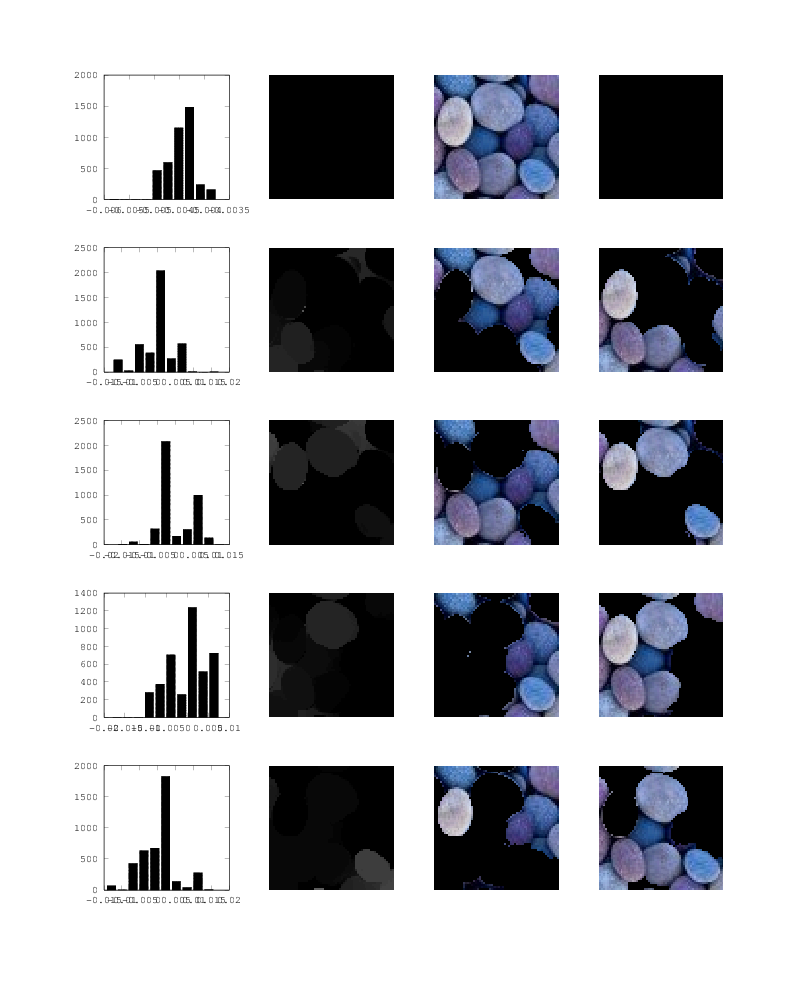

In [9]:
figure('Position',[1000,0,800,1000]);
for i = 1:k
    subplot(k, 4, (i-1) * 4 + 1);
    hist(V(:, i));
    
    subplot(k, 4, (i-1) * 4 + 2);
    v_sq = reshape(V(:, i), h, h);
    imshow(v_sq ./ (norm(v_sq) * 0.2));
    cluster1 = im_orig; cluster2 = im_orig;
    for ii = 1:h
        for jj = 1:h
            if(v_sq(ii, jj) < 0)
                cluster2(ii, jj, :) = zeros(3, 1);
            else
                cluster1(ii, jj, :) = zeros(3, 1);
            end
        end
    end
    subplot(k, 4, (i-1) * 4 + 3);
    imshow(cluster1);
    subplot(k, 4, (i-1) * 4 + 4);
    imshow(cluster2);
end

### Bonus

In [10]:
v_norm = V ./ norm(V);

We refer to a simple kmeans implementation as it is hard to import third party libraries for octave. 

In [11]:
% https://gist.github.com/eminaksehirli/2fb6346b24ea16b6c121
function  [assignments, centers] = kmeans(X, k, centers = 0, maxiter = 200)
% INPUTS:   X = N*d matrix of dataset, rows of X correspond to N data points; 
%               columns correspond to attributes.
%           k = number of clusters
%     centers = Starting centers of clusters.
%     maxiter = Maximum iteration count for convergence.

    if (centers == 0)
        centerRows = randperm(size(X)(1));
        centers = X(centerRows(1:k), :);
    endif
    numOfRows = length(X(:,1));
    numOfFeatures = length(X(1,:));
    assignments = ones(1, numOfRows);

    for iter = 1:maxiter
        clusterTotals = zeros(k, numOfFeatures);
        clusterSizes = zeros(k, 1);
        for rowIx = 1:numOfRows
            minDist = realmax;
            assignTo = 0;
            for centerIx = 1:k 
                % Euclidian distance is used.
                dist = sqrt(sum((X(rowIx, : ) - centers(centerIx, :)).^2));
                if dist < minDist
                    minDist = dist;
                    assignTo = centerIx;
                endif
            endfor
            assignments(rowIx) = assignTo;

            % Keep these information to calculate cluster centers.
            clusterTotals(assignTo, :) += X(rowIx, :);
            clusterSizes(assignTo)++;
        endfor

        % This process is called 'singleton' in terms of Matlab. 
        % If a cluster is empty choose a random data point as new 
        % cluster cener.
        for clusterIx = 1:k
            if (clusterSizes(clusterIx) == 0)
                randomRow = round(1 + rand() * (numOfRows - 1) );
                clusterTotals(clusterIx, :) =  X(randomRow, :);
                clusterSizes(clusterIx) = 1;
            endif
        endfor

        newCenters = zeros(k, numOfFeatures);
        for centerIx = 1:k 
            newCenters(centerIx, :) = clusterTotals(centerIx, : ) / clusterSizes(centerIx);
        endfor

        diff = sum(sum(abs(newCenters - centers)));

        if diff < eps
            %disp('Centers are same, which means we converged before maxiteration count. This is a good thing!')
            break;
        endif

        centers = newCenters;
    endfor
    assignments = assignments';
    %printf('iter: %d, diff: %f\n', iter, diff);
endfunction

In [12]:
[assignments, centers] = kmeans(v_norm, 16);

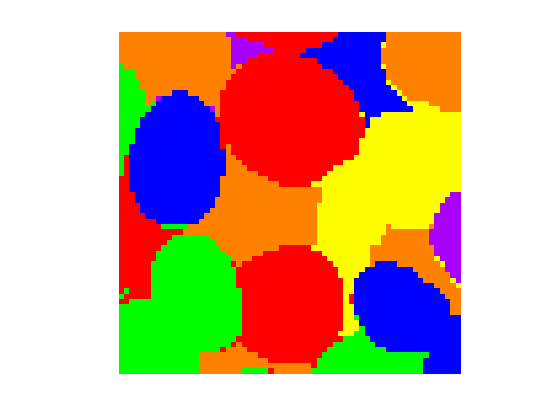

In [13]:
imshow(ind2rgb(reshape(assignments, h, h), prism()));